In [216]:
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
%matplotlib inline
import seaborn as sns
import warnings
import plotly.express as px
import gc
import folium
from tqdm import tqdm
from math import radians, cos, sin, asin, sqrt
from sklearn.model_selection import train_test_split

# csv to parquet 데이터 불러오기

In [217]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./datasets/{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [277]:
csv_to_parquet('./datasets/train.csv', 'train')
csv_to_parquet('./datasets/test.csv', 'test')

train Done.
test Done.
data_info Done.


In [282]:
train = pd.read_parquet('./datasets/train.parquet')
test = pd.read_parquet('./datasets/test.parquet')
data_info = pd.read_csv('./datasets/data_info.csv')

# 자료형 변환

In [288]:
# 빠른 탐색을 위한 자료형 변환
to_int8 = ["day_of_week","weight_restricted", "base_hour", "lane_count", "road_rating", 
           "road_name","road_type", "start_turn_restricted", "end_turn_restricted", 
           "maximum_speed_limit", ]
to_int16 = ["start_node_name", "end_node_name"]
to_int32 = ["base_date"]

for i in to_int8:
    train[i] = train[i].astype("int8")
for j in to_int16:
    train[j] = train[j].astype("int16")
for k in to_int32:
    train[k] = train[k].astype("int32")

In [ ]:
train.columns

In [29]:
train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,목,16,1,107,-,0,0,50.0,...,0,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0
4701213,TRAIN_4701213,20220331,목,2,2,107,-,0,0,80.0,...,3,광삼교,33.472505,126.424368,없음,광삼교,33.472525,126.424890,없음,65.0
4701214,TRAIN_4701214,20220613,월,22,2,103,일반국도12호선,0,0,60.0,...,0,고성교차로,33.447183,126.912579,없음,성산교차로,33.444121,126.912948,없음,30.0
4701215,TRAIN_4701215,20211020,수,2,2,103,일반국도95호선,0,0,80.0,...,0,제6광령교,33.443596,126.431817,없음,관광대학입구,33.444996,126.433332,없음,73.0


# 1. 데이터 훑어보기

In [ ]:
data_info

In [6]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [20]:
train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,connect_code,maximum_speed_limit,weight_restricted,...,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,year,month,day
0,TRAIN_0000000,2022-06-23,1,17,1,106,46,0,60.0,32400.0,...,126.662612,0,386,33.427749,126.662335,0,52.0,2022,6,23
1,TRAIN_0000001,2022-07-28,1,21,2,103,34,0,60.0,0.0,...,126.529107,1,2,33.504811,126.526240,0,30.0,2022,7,28
2,TRAIN_0000002,2021-10-10,4,7,2,103,36,0,80.0,0.0,...,126.368598,0,179,33.280072,126.362147,0,61.0,2021,10,10
3,TRAIN_0000003,2022-03-11,0,13,2,107,57,0,50.0,0.0,...,126.567204,0,203,33.245565,126.566228,0,20.0,2022,3,11
4,TRAIN_0000004,2021-10-05,6,8,2,103,35,0,80.0,0.0,...,126.326551,0,269,33.462677,126.330152,0,38.0,2021,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,2021-11-04,1,16,1,107,0,0,50.0,0.0,...,126.278125,0,42,33.420955,126.273750,0,20.0,2021,11,4
4701213,TRAIN_4701213,2022-03-31,1,2,2,107,0,0,80.0,43200.0,...,126.424368,0,31,33.472525,126.424890,0,65.0,2022,3,31
4701214,TRAIN_4701214,2022-06-13,3,22,2,103,35,0,60.0,0.0,...,126.912579,0,214,33.444121,126.912948,0,30.0,2022,6,13
4701215,TRAIN_4701215,2021-10-20,2,2,2,103,37,0,80.0,0.0,...,126.431817,0,23,33.444996,126.433332,0,73.0,2021,10,20


In [ ]:
train['multi_linked']

#### 범주형 데이터 확인 

In [83]:
train['base_hour'].value_counts()

15    214541
13    214297
14    214182
12    211833
19    209870
11    208515
16    208420
17    208377
18    207500
10    206316
9     205327
20    205059
21    203585
8     201875
22    200629
7     199061
6     189418
23    184229
1     182353
5     181128
2     169322
4     165284
3     155938
0     154158
Name: base_hour, dtype: int64

In [84]:
train['road_rating'].value_counts()

103    2159511
107    1582214
106     959492
Name: road_rating, dtype: int64

In [86]:
train['maximum_speed_limit'].value_counts()

60.0    1665573
50.0    1103682
70.0     995077
80.0     700334
30.0     229761
40.0       6790
Name: maximum_speed_limit, dtype: int64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [14]:
train.describe()

,base_date,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,end_latitude,end_longitude,target
count,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4701217.0,4.701217e+06,4701217.0,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06
mean,2.021672e+07,1.192820e+01,1.836651e+00,1.049585e+02,4.762597e-04,2.660218e-01,6.125329e+01,0.0,5.618742e+03,0.0,6.152237e-01,3.338432e+01,1.265217e+02,3.338432e+01,1.265217e+02,4.278844e+01
std,4.555709e+03,6.722092e+00,6.877513e-01,1.840107e+00,2.181818e-02,5.227760e+00,1.213354e+01,0.0,1.395343e+04,0.0,1.211268e+00,1.012015e-01,1.563657e-01,1.011948e-01,1.563519e-01,1.595443e+01
min,2.021090e+07,0.000000e+00,1.000000e+00,1.030000e+02,0.000000e+00,0.000000e+00,3.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.324343e+01,1.261826e+02,3.324343e+01,1.261826e+02,1.000000e+00
25%,2.021110e+07,6.000000e+00,1.000000e+00,1.030000e+02,0.000000e+00,0.000000e+00,5.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.326422e+01,1.264232e+02,3.326422e+01,1.264232e+02,3.000000e+01
50%,2.022013e+07,1.200000e+01,2.000000e+00,1.060000e+02,0.000000e+00,0.000000e+00,6.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.341257e+01,1.265112e+02,3.341257e+01,1.265112e+02,4.300000e+01
75%,2.022050e+07,1.800000e+01,2.000000e+00,1.070000e+02,0.000000e+00,0.000000e+00,7.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.347804e+01,1.265840e+02,3.347804e+01,1.265840e+02,5.400000e+01
max,2.022073e+07,2.300000e+01,3.000000e+00,1.070000e+02,1.000000e+00,1.030000e+02,8.000000e+01,0.0,5.000000e+04,0.0,3.000000e+00,3.355608e+01,1.269309e+02,3.355608e+01,1.269309e+02,1.130000e+02


In [93]:
train['base_date']

0          20220623
1          20220728
2          20211010
3          20220311
4          20211005
             ...   
4701212    20211104
4701213    20220331
4701214    20220613
4701215    20211020
4701216    20211019
Name: base_date, Length: 4701217, dtype: int64

In [107]:
train.base_date

0          20220623
1          20220728
2          20211010
3          20220311
4          20211005
             ...   
4701212    20211104
4701213    20220331
4701214    20220613
4701215    20211020
4701216    20211019
Name: base_date, Length: 4701217, dtype: int64

In [106]:
# 최고 제한속도 확인
train.maximum_speed_limit.value_counts().sort_index()

30.0     229761
40.0       6790
50.0    1103682
60.0    1665573
70.0     995077
80.0     700334
Name: maximum_speed_limit, dtype: int64

In [62]:
# 차로 수 확인
train.lane_count.value_counts()

2    2352092
1    1558531
3     790594
Name: lane_count, dtype: int64

# 2. 시각화

array([[<AxesSubplot:title={'center':'base_date'}>,
        <AxesSubplot:title={'center':'base_hour'}>,
        <AxesSubplot:title={'center':'lane_count'}>,
        <AxesSubplot:title={'center':'road_rating'}>],
       [<AxesSubplot:title={'center':'multi_linked'}>,
        <AxesSubplot:title={'center':'connect_code'}>,
        <AxesSubplot:title={'center':'maximum_speed_limit'}>,
        <AxesSubplot:title={'center':'vehicle_restricted'}>],
       [<AxesSubplot:title={'center':'weight_restricted'}>,
        <AxesSubplot:title={'center':'height_restricted'}>,
        <AxesSubplot:title={'center':'road_type'}>,
        <AxesSubplot:title={'center':'start_latitude'}>],
       [<AxesSubplot:title={'center':'start_longitude'}>,
        <AxesSubplot:title={'center':'end_latitude'}>,
        <AxesSubplot:title={'center':'end_longitude'}>,
        <AxesSubplot:title={'center':'target'}>]], dtype=object)

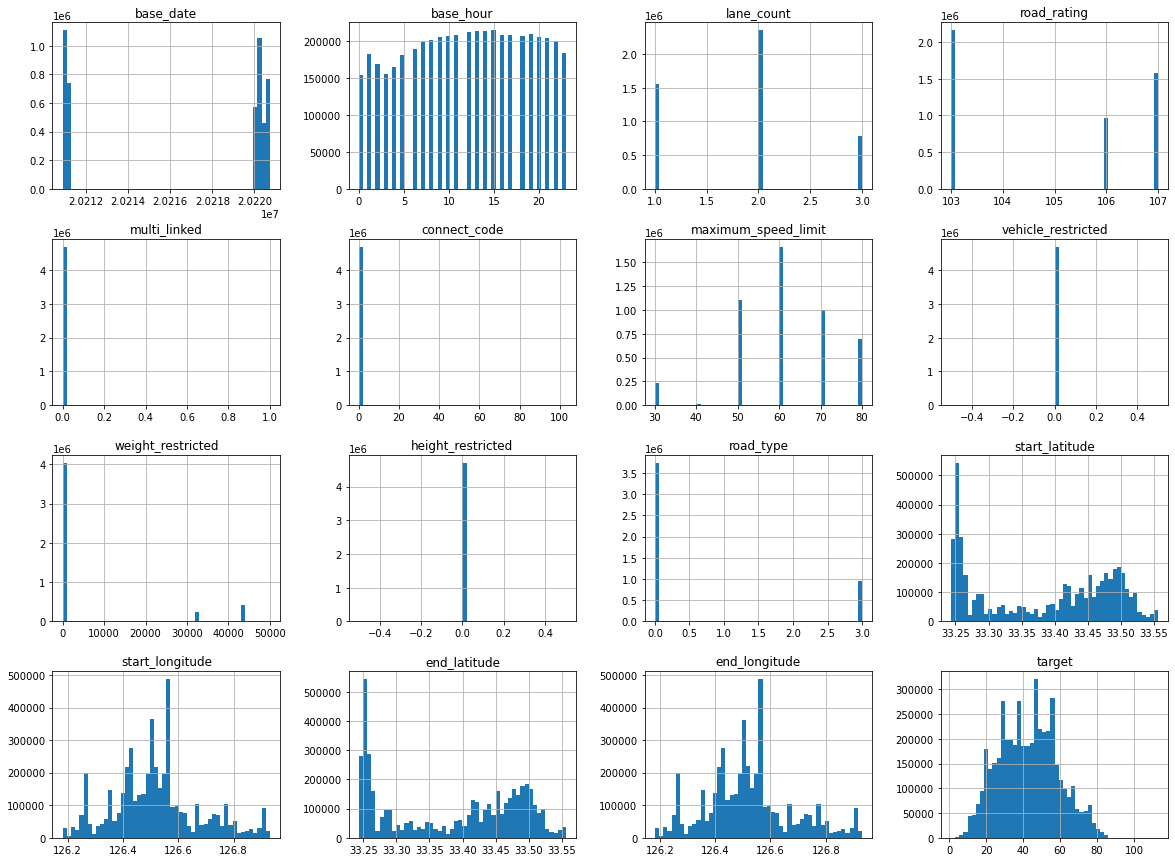

In [130]:
train.hist(bins=50, figsize=(20, 15)) 

#### 히스토그램 그래프를 보아 "multi_linked"와 "vehicle_restricted", "height_restricted" 같은 의미없는 데이터는 전처리과정에서 삭제

<AxesSubplot:xlabel='start_longitude', ylabel='start_latitude'>

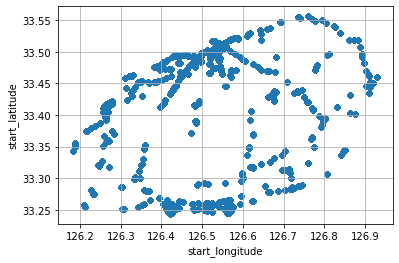

In [35]:
train.plot(kind='scatter', x='start_longitude', y='start_latitude', alpha=0.3, grid=True)

In [ ]:
# map
m = folium.Map(location=[33.427747, 126.662612], zoom_start=10.4, tiles="Stamen Terrain")

tooltip = "Click me!"
a=train[['start_latitude','start_longitude','start_node_name']]
a = a.drop_duplicates()
b=a['start_longitude']
c=a['start_node_name']
a=a['start_latitude']

for i,j,k in zip(a,b,c) :
    folium.Marker([i, j], popup="<i>{}</i>".format(k), tooltip=tooltip).add_to(m)
#m

In [7]:
gps = train[['start_longitude', 'end_longitude', 'start_latitude', 'end_latitude', 'target']]

In [9]:
gps_set = [gps['start_longitude'].min(), gps['start_longitude'].max(), gps['start_latitude'].min(), gps['start_latitude'].max()] # 지도 그림의 gps 좌표
gps_set

[126.182616549771, 126.930940973848, 33.2434317486804, 33.5560801767072]

In [ ]:
from tqdm import tqdm

In [49]:
vel_low_idx = gps.loc[gps['target']<15].index # 시내 교통 체증기준 10 km/h 미만
vel_high_idx = gps.loc[gps['target']>80].index # 고속도로 원활기준 80 km/h 초과

100%|██████████| 26239/26239 [00:16<00:00, 1558.22it/s]


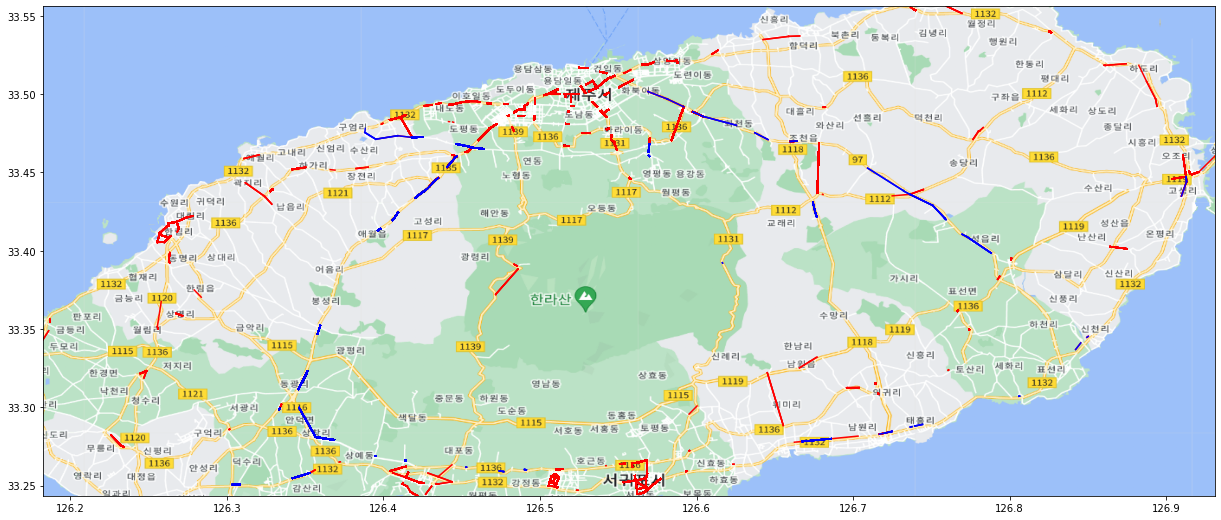

In [84]:

f, ax = plt.subplots(figsize=(21,10))

ax.set_xlim(gps_set[0], gps_set[1])
ax.set_ylim(gps_set[2], gps_set[3])

image = plt.imread('map5.png')
ax.imshow(image, zorder=0, extent=gps_set, aspect='equal')

for i in tqdm(vel_low_idx): # 교통 체증 도로 빨강
    x_1 = gps.loc[i,'start_longitude']
    x_2 = gps.loc[i,'end_longitude'] 
    y_1 = gps.loc[i,'start_latitude']
    y_2 = gps.loc[i,'end_latitude'] 
    ax.plot([x_1, x_2], [y_1, y_2], color='red')

for i in tqdm(vel_high_idx): # 교통 원활 도로 파랑
    x_1 = gps.loc[i,'start_longitude']
    x_2 = gps.loc[i,'end_longitude'] 
    y_1 = gps.loc[i,'start_latitude']
    y_2 = gps.loc[i,'end_latitude'] 
    ax.plot([x_1, x_2], [y_1, y_2], color='blue')

plt.show()

C:\Users\Playdata\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='maximum_speed_limit', ylabel='Density'>

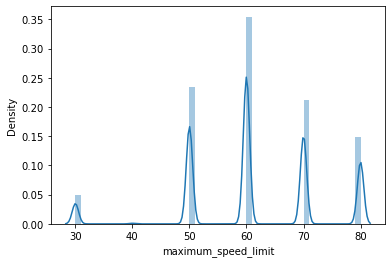

In [58]:
sns.distplot(train.maximum_speed_limit)

<AxesSubplot:xlabel='maximum_speed_limit', ylabel='target'>

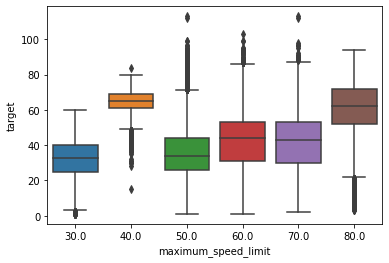

In [59]:
sns.boxplot(x = "maximum_speed_limit", y = "target", data = train)

#### maximum_spped_limit 극단치확인 전처리과정에서 제거

<AxesSubplot:xlabel='target', ylabel='Count'>

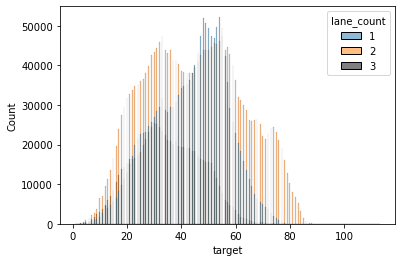

In [63]:
sns.histplot(x = train.target, hue = train.lane_count, palette=["C0", "C1", "k"])

##### 차로 수 확인

In [71]:
for i in train.groupby("lane_count")["target"].mean() :
    print(i)

43.57056163785
44.9157129057877
34.917783337591736


<AxesSubplot:xlabel='lane_count', ylabel='target'>

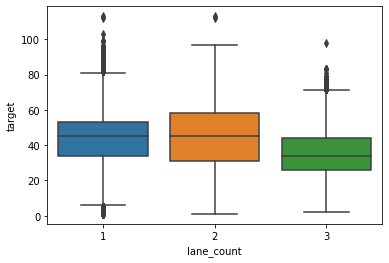

In [82]:
sns.boxplot(x = train.lane_count, y = train.target)



##### 예상과는 반대로 차선이 수가 늘어날 수록 오히려 정체되는 모습을 보임. 모델학습 시 활용

# 3. 상관관계

In [10]:
# target 0.2이상 관계
corr = train.corr()
corr[(corr['target']>0.2)]

C:\Users\Playdata\AppData\Local\Temp\ipykernel_10968\3211421322.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


,base_date,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,end_latitude,end_longitude,target
maximum_speed_limit,-0.018713,-0.036756,0.384002,-0.327474,-0.020245,-0.015190,1.000000,NaN,0.085080,NaN,0.059511,0.253147,-0.033018,0.252958,-0.032907,0.425715
weight_restricted,-0.011030,-0.003231,-0.177224,-0.118630,-0.008790,-0.020491,0.085080,NaN,1.000000,NaN,0.792803,-0.128291,0.034926,-0.128305,0.034915,0.294092
road_type,-0.004599,-0.007880,-0.050715,-0.125618,0.042977,-0.025846,0.059511,NaN,0.792803,NaN,1.000000,-0.043420,0.033684,-0.043430,0.033664,0.200840
target,-0.033997,-0.159407,-0.144256,-0.261693,-0.008408,0.048348,0.425715,NaN,0.294092,NaN,0.200840,0.036280,-0.001168,0.036139,-0.001000,1.000000


<AxesSubplot:>

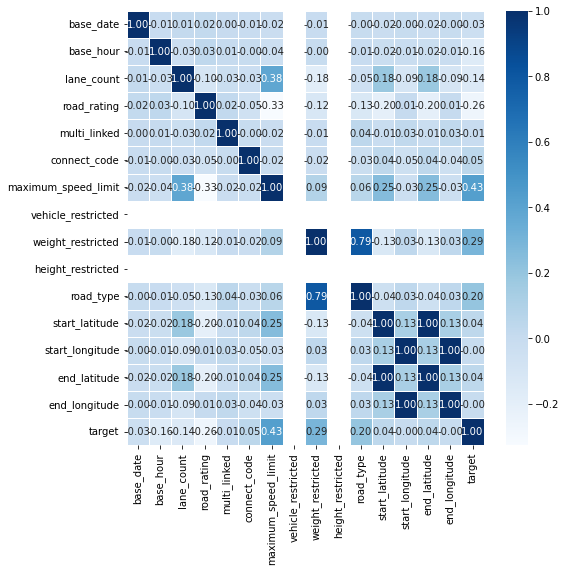

In [10]:
plt.figure(figsize=(8,8)) 
sns.heatmap(corr, annot=True, fmt='.2f', linewidths=0.5, cmap='Blues')

# 4. 데이터 전처리와 재시각화

In [289]:
all_data = pd.concat([train,test], axis=0, ignore_index=True)
all_data

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992453,TEST_291236,20220827,토,5,1,103,일반국도16호선,0,0,80.0,...,0,월산마을,33.472819,126.463030,없음,도근교,33.470483,126.460846,없음,NaN
4992454,TEST_291237,20220819,금,20,2,103,일반국도11호선,0,0,60.0,...,0,영주교,33.305359,126.598914,없음,하례입구삼거리,33.300796,126.600332,없음,NaN
4992455,TEST_291238,20220805,금,11,1,107,신대로,0,0,30.0,...,0,마리나사거리,33.493624,126.496769,있음,칠오광장사거리,33.497500,126.496946,있음,NaN
4992456,TEST_291239,20220812,금,7,2,107,경찰로,0,0,60.0,...,0,국민의료보험관리공단,33.254782,126.507014,없음,의료보험조합,33.255659,126.507333,없음,NaN


## 4-1 널 값 확인

In [290]:
all_data.isnull().sum()

id                            0
base_date                     0
day_of_week                   0
base_hour                     0
lane_count                    0
road_rating                   0
road_name                     0
multi_linked                  0
connect_code                  0
maximum_speed_limit           0
vehicle_restricted            0
weight_restricted             0
height_restricted             0
road_type                     0
start_node_name               0
start_latitude                0
start_longitude               0
start_turn_restricted         0
end_node_name                 0
end_latitude                  0
end_longitude                 0
end_turn_restricted           0
target                   291241
dtype: int64

## 4-2 중복 데이터 삭제

### 4-2-1 형상 확인

In [291]:
all_data.shape

(4992458, 23)

### 4-2-2 중복 데이터 삭제

In [292]:
all_data = all_data.drop_duplicates()

In [293]:
train.shape

(4701217, 23)

## 4-3 변수 삭제

### 4-3-1 유일한 컬럼 탐색

In [294]:
train_desc = train.describe().transpose()
train_desc[train_desc['std']==0].index

Index(['vehicle_restricted', 'height_restricted'], dtype='object')

### 4-3-2 height_restricted, vehicle_restricted 변수 삭제

In [295]:
all_data=all_data.drop('height_restricted',axis=1)
all_data=all_data.drop('vehicle_restricted',axis=1)
all_data=all_data.drop('multi_linked',axis=1)

## 4-4 파생변수 생성 및 변경

### 4-4-1  지리데이터 변수 생성 (위도와 경도의 시작과 끝 차이)

In [296]:
all_data['lat_change'] = all_data['start_latitude'] - all_data['end_latitude']
all_data['lon_change'] = all_data['start_longitude'] - all_data['end_longitude']
all_data['lat_change']

0         -0.000001
1         -0.004081
2         -0.000927
3          0.000515
4         -0.000462
             ...   
4992453    0.002336
4992454    0.004563
4992455   -0.003876
4992456   -0.000877
4992457   -0.000057
Name: lat_change, Length: 4992458, dtype: float64

In [297]:
all_data['lon_change']

0          0.000277
1          0.002867
2          0.006450
3          0.000976
4         -0.003601
             ...   
4992453    0.002184
4992454   -0.001418
4992455   -0.000177
4992456   -0.000319
4992457    0.000855
Name: lon_change, Length: 4992458, dtype: float64

## 4-4 두 지점 사이의 거리 변수 생성

In [298]:
def haversine(row):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1 = row['start_longitude']
    lat1 = row['start_latitude']
    lon2 = row['end_longitude']
    lat2 = row['end_latitude']

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km


In [299]:
all_data['distance'] = all_data.apply(haversine, axis=1)

In [300]:
all_data['distance']

0          0.025694
1          0.525560
2          0.608016
3          0.107285
4          0.337736
             ...   
4992453    0.329145
4992454    0.523857
4992455    0.431061
4992456    0.101872
4992457    0.079721
Name: distance, Length: 4992458, dtype: float64

### 4-5 road_name 컬럼 "-" (결측값) 제거

In [301]:
drop_road_name_index = all_data[all_data["road_name"] == "-"].index
temp_all_data = all_data.iloc[drop_road_name_index]
temp_all_data

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,connect_code,maximum_speed_limit,weight_restricted,...,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,lat_change,lon_change,distance
6,TRAIN_0000006,20220106,목,0,2,107,-,0,60.0,0.0,...,126.268029,없음,나동,33.414175,126.269378,없음,39.0,0.004237,-0.001349,0.487165
14,TRAIN_0000014,20220203,목,16,1,107,-,0,60.0,43200.0,...,126.624634,없음,송목교,33.317065,126.623867,없음,58.0,-0.000152,0.000767,0.073214
28,TRAIN_0000028,20220612,일,14,2,107,-,0,50.0,0.0,...,126.354179,없음,금악,33.330673,126.354987,없음,59.0,0.000149,-0.000808,0.076826
30,TRAIN_0000030,20220623,목,6,2,107,-,0,80.0,0.0,...,126.418443,없음,상귀교차로,33.473390,126.409129,없음,75.0,-0.001114,0.009314,0.872175
31,TRAIN_0000031,20211028,목,15,1,107,-,0,60.0,43200.0,...,126.695809,없음,남수교,33.337398,126.696117,없음,36.0,-0.000154,-0.000308,0.033301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992305,TEST_291088,20220819,금,21,2,107,-,0,80.0,0.0,...,126.454022,없음,무수천제2교,33.468158,126.446369,없음,NaN,-0.001551,0.007653,0.730071
4992310,TEST_291093,20220819,금,13,2,107,-,0,50.0,0.0,...,126.414236,없음,산신주유소,33.255431,126.413687,없음,NaN,-0.000216,0.000549,0.056395
4992352,TEST_291135,20220823,화,0,2,107,-,0,50.0,0.0,...,126.414236,없음,산신주유소,33.255431,126.413687,없음,NaN,-0.000216,0.000549,0.056395
4992403,TEST_291186,20220819,금,16,2,107,-,0,30.0,0.0,...,126.422025,없음,천제이교,33.244882,126.419089,없음,NaN,-0.001450,0.002936,0.316908


In [302]:
# .loc로 값 대체하기 전의 수 = 569463
print(len(all_data[all_data["road_name"] == "-"]))
all_data.loc[(all_data["road_rating"] == 107) & (all_data["weight_restricted"] == 32400.0) & (all_data["road_name"] == "-"), "road_name"] = "산서로"
all_data.loc[(all_data["road_rating"] == 107) & (all_data["weight_restricted"] == 43200.0) & (all_data["road_name"] == "-"), "road_name"] = "중문로"

test.loc[(test["road_rating"] == 107) & (test["weight_restricted"] == 32400.0) & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["road_rating"] == 107) & (test["weight_restricted"] == 43200.0) & (test["road_name"] == "-"), "road_name"] = "중문로"

# .loc로 값 대체한 이후의 수 = 481943
print(len(all_data[all_data["road_name"] == "-"]))

582063
493200


In [303]:
for i in all_data["start_node_name"].unique():
    if (len(all_data[(all_data["start_node_name"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in all_data[(all_data["start_node_name"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(all_data[(all_data["start_node_name"] == i)]["road_name"].value_counts())

---------------- 송목교 -------------------
중문로    10390
-       5183
Name: road_name, dtype: int64
---------------- 남수교 -------------------
중문로    10360
-       5156
Name: road_name, dtype: int64
---------------- 하귀입구 -------------------
일반국도12호선    10656
-            5190
Name: road_name, dtype: int64
---------------- 양계장 -------------------
-           5330
일반국도12호선    5329
Name: road_name, dtype: int64
---------------- 난산입구 -------------------
지방도1119호선    4923
-            3113
Name: road_name, dtype: int64
---------------- 영주교 -------------------
일반국도11호선    26799
-             472
Name: road_name, dtype: int64
---------------- 서중2교 -------------------
중문로    10380
-       5204
Name: road_name, dtype: int64
---------------- 천제이교 -------------------
-      12288
산서로    12049
Name: road_name, dtype: int64
---------------- 하나로교 -------------------
중문로    10578
-       5282
Name: road_name, dtype: int64
---------------- 신하교 -------------------
중문로    10390
-       5205
Name: road_name, 

In [304]:
print(len(all_data[all_data["road_name"] == "-"]))

all_data.loc[(all_data["start_node_name"] == "송목교") & (all_data["road_name"] == "-"), "road_name"] = "중문로"
all_data.loc[(all_data["start_node_name"] == "남수교") & (all_data["road_name"] == "-"), "road_name"] = "중문로"
all_data.loc[(all_data["start_node_name"] == "하귀입구") & (all_data["road_name"] == "-"), "road_name"] = "일반국도12호선"
all_data.loc[(all_data["start_node_name"] == "양계장") & (all_data["road_name"] == "-"), "road_name"] = "일반국도12호선"
all_data.loc[(all_data["start_node_name"] == "난산입구") & (all_data["road_name"] == "-"), "road_name"] = "지방도1119호선"
all_data.loc[(all_data["start_node_name"] == "영주교") & (all_data["road_name"] == "-"), "road_name"] = "일반국도11호선"
all_data.loc[(all_data["start_node_name"] == "서중2교") & (all_data["road_name"] == "-"), "road_name"] = "중문로"
all_data.loc[(all_data["start_node_name"] == "천제이교") & (all_data["road_name"] == "-"), "road_name"] = "산서로"
all_data.loc[(all_data["start_node_name"] == "하나로교") & (all_data["road_name"] == "-"), "road_name"] = "중문로"
all_data.loc[(all_data["start_node_name"] == "신하교") & (all_data["road_name"] == "-"), "road_name"] = "중문로"
all_data.loc[(all_data["start_node_name"] == "야영장") & (all_data["road_name"] == "-"), "road_name"] = "관광단지1로"
all_data.loc[(all_data["start_node_name"] == "월계교") & (all_data["road_name"] == "-"), "road_name"] = "산서로"
all_data.loc[(all_data["start_node_name"] == "서울이용원") & (all_data["road_name"] == "-"), "road_name"] = "태평로"
all_data.loc[(all_data["start_node_name"] == "김녕교차로") & (all_data["road_name"] == "-"), "road_name"] = "일반국도12호선"
all_data.loc[(all_data["start_node_name"] == "어도초등교") & (all_data["road_name"] == "-"), "road_name"] = "일반국도16호선"
all_data.loc[(all_data["start_node_name"] == "광삼교") & (all_data["road_name"] == "-"), "road_name"] = "중문로"
all_data.loc[(all_data["start_node_name"] == "오렌지농원") & (all_data["road_name"] == "-"), "road_name"] = "일반국도11호선"
all_data.loc[(all_data["start_node_name"] == "우사") & (all_data["road_name"] == "-"), "road_name"] = "일반국도16호선"
all_data.loc[(all_data["start_node_name"] == "서귀포시산림조합") & (all_data["road_name"] == "-"), "road_name"] = "지방도1136호선"
all_data.loc[(all_data["start_node_name"] == "성읍삼거리") & (all_data["road_name"] == "-"), "road_name"] = "일반국도16호선"

print(len(all_data[all_data["road_name"] == "-"]))


493200
388357


In [305]:
# "-" 값 대체를 위한 탐색"
for i in all_data["end_node_name"].unique():
    if (len(all_data[(all_data["end_node_name"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in all_data[(all_data["end_node_name"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(all_data[(all_data["end_node_name"] == i)]["road_name"].value_counts())


---------------- 남수교 -------------------
중문로    10360
-       5187
Name: road_name, dtype: int64
---------------- 농협주유소 -------------------
-      8053
산서로    5089
Name: road_name, dtype: int64
---------------- 난산입구 -------------------
지방도1119호선    4978
-            2946
Name: road_name, dtype: int64
---------------- 성읍삼거리 -------------------
일반국도16호선    5030
-           4670
Name: road_name, dtype: int64
---------------- 김녕교차로 -------------------
일반국도12호선    5281
-           3266
Name: road_name, dtype: int64
---------------- 한남교차로 -------------------
중문로    5204
-      5198
Name: road_name, dtype: int64
---------------- 서울이용원 -------------------
태평로    13073
-       1417
Name: road_name, dtype: int64
---------------- 하귀입구 -------------------
일반국도12호선    10661
-            5144
Name: road_name, dtype: int64
---------------- 우사 -------------------
일반국도16호선    7677
-           4784
Name: road_name, dtype: int64
---------------- 어도초등교 -------------------
-           7053
일반국도16호선    5135

In [306]:
print(len(all_data[all_data["road_name"] == "-"]))

all_data.loc[(all_data["end_node_name"] == "남수교") & (all_data["road_name"] == "-"), "road_name"] = "중문로"
all_data.loc[(all_data["end_node_name"] == "농협주유소") & (all_data["road_name"] == "-"), "road_name"] = "월계교"
all_data.loc[(all_data["end_node_name"] == "난산입구") & (all_data["road_name"] == "-"), "road_name"] = "지방도1119호선"
all_data.loc[(all_data["end_node_name"] == "성읍삼거리") & (all_data["road_name"] == "-"), "road_name"] = "일반국도16호선"
all_data.loc[(all_data["end_node_name"] == "김녕교차로") & (all_data["road_name"] == "-"), "road_name"] = "일반국도12호선"
all_data.loc[(all_data["end_node_name"] == "한남교차로") & (all_data["road_name"] == "-"), "road_name"] = "서중2교"
all_data.loc[(all_data["end_node_name"] == "서울이용원") & (all_data["road_name"] == "-"), "road_name"] = "태평로"
all_data.loc[(all_data["end_node_name"] == "하귀입구") & (all_data["road_name"] == "-"), "road_name"] = "일반국도12호선"
all_data.loc[(all_data["end_node_name"] == "어도초등교") & (all_data["road_name"] == "-"), "road_name"] = "일반국도16호선"
all_data.loc[(all_data["end_node_name"] == "월계교") & (all_data["road_name"] == "-"), "road_name"] = "산서로"
all_data.loc[(all_data["end_node_name"] == "양계장") & (all_data["road_name"] == "-"), "road_name"] = "일반국도12호선"
all_data.loc[(all_data["end_node_name"] == "하나로교") & (all_data["road_name"] == "-"), "road_name"] = "중문로"
all_data.loc[(all_data["end_node_name"] == "광삼교") & (all_data["road_name"] == "-"), "road_name"] = "중문로"
all_data.loc[(all_data["end_node_name"] == "수간교차로") & (all_data["road_name"] == "-"), "road_name"] = "양계장"
all_data.loc[(all_data["end_node_name"] == "난산사거리") & (all_data["road_name"] == "-"), "road_name"] = "난산입구"
all_data.loc[(all_data["end_node_name"] == "서중2교") & (all_data["road_name"] == "-"), "road_name"] = "중문로"
all_data.loc[(all_data["end_node_name"] == "서귀포시산림조합") & (all_data["road_name"] == "-"), "road_name"] = "지방도1136호선"
all_data.loc[(all_data["end_node_name"] == "옹포사거리") & (all_data["road_name"] == "-"), "road_name"] = "월계교"
all_data.loc[(all_data["end_node_name"] == "진은교차로") & (all_data["road_name"] == "-"), "road_name"] = "하나로교"
print(len(all_data[all_data["road_name"] == "-"]))


388357
290706


In [307]:
# 소숫점 문제상 출력된 값을 그대로 사용한다면 값을 대체할 수 없는 문제가 있습니다.
# 이를 해결하기 위해서 소숫점의 자릿수를 제한하겠습니다.
print(all_data["start_latitude"].nunique(),all_data["start_longitude"].nunique(), all_data["end_latitude"].nunique(), all_data["end_longitude"].nunique())

# 7번째자리에서 반올림 할 경우 all_data에서의 고윳값 갯수가 변하지 않습니다
all_data[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]] = all_data[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]].apply(lambda x: round(x, 6))

print(all_data["start_latitude"].nunique(),all_data["start_longitude"].nunique(), all_data["end_latitude"].nunique(), all_data["end_longitude"].nunique())


586 586 586 586
586 586 586 586


In [308]:
for i in all_data["start_latitude"].unique():
    if (len(all_data[(all_data["start_latitude"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in all_data[(all_data["start_latitude"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(all_data[(all_data["start_latitude"] == i)]["road_name"].value_counts())


---------------- 33.409416 -------------------
-      3321
월계교    3184
Name: road_name, dtype: int64
---------------- 33.402546 -------------------
-            2953
지방도1119호선    2946
Name: road_name, dtype: int64
---------------- 33.471164 -------------------
-           5334
일반국도12호선    5331
Name: road_name, dtype: int64
---------------- 33.411255 -------------------
-      7382
월계교    4338
Name: road_name, dtype: int64
---------------- 33.405319 -------------------
산서로    4821
-      4159
Name: road_name, dtype: int64
---------------- 33.322018 -------------------
서중2교    5198
-       2396
Name: road_name, dtype: int64
---------------- 33.325096 -------------------
중문로    5187
-      5187
Name: road_name, dtype: int64
---------------- 33.408431 -------------------
-      8441
산서로    4777
Name: road_name, dtype: int64
---------------- 33.284189 -------------------
중문로    5306
-      5288
Name: road_name, dtype: int64
---------------- 33.47339 -------------------
-      5344
양계장    53

In [309]:
print(len(all_data[all_data["road_name"] == "-"]))

all_data.loc[(all_data["start_latitude"] == 33.409416) & (all_data["road_name"] == "-"), "road_name"] = "월계교"
all_data.loc[(all_data["start_latitude"] == 33.402546) & (all_data["road_name"] == "-"), "road_name"] = "지방도1119호선"
all_data.loc[(all_data["start_latitude"] == 33.471164) & (all_data["road_name"] == "-"), "road_name"] = "일반국도12호선"
all_data.loc[(all_data["start_latitude"] == 33.411255) & (all_data["road_name"] == "-"), "road_name"] = "월계교"
all_data.loc[(all_data["start_latitude"] == 33.405319) & (all_data["road_name"] == "-"), "road_name"] = "산서로"
all_data.loc[(all_data["start_latitude"] == 33.322018) & (all_data["road_name"] == "-"), "road_name"] = "서중2교"
all_data.loc[(all_data["start_latitude"] == 33.325096) & (all_data["road_name"] == "-"), "road_name"] = "중문로"
all_data.loc[(all_data["start_latitude"] == 33.408431) & (all_data["road_name"] == "-"), "road_name"] = "산서로"
all_data.loc[(all_data["start_latitude"] == 33.284189) & (all_data["road_name"] == "-"), "road_name"] = "중문로"
all_data.loc[(all_data["start_latitude"] == 33.47339) & (all_data["road_name"] == "-"), "road_name"] = "양계장"

print(len(all_data[all_data["road_name"] == "-"]))

290706
240901


In [310]:
# "-" 값 대체를 위한 탐색"
for i in all_data["end_latitude"].unique():
    if (len(all_data[(all_data["end_latitude"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in all_data[(all_data["end_latitude"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(all_data[(all_data["end_latitude"] == i)]["road_name"].value_counts())


---------------- 33.47339 -------------------
-           5338
일반국도12호선    5334
Name: road_name, dtype: int64
---------------- 33.358358 -------------------
-           4784
일반국도16호선    2251
Name: road_name, dtype: int64
---------------- 33.412573 -------------------
-      4389
월계교    4199
Name: road_name, dtype: int64
---------------- 33.244882 -------------------
-      6221
산서로    6086
Name: road_name, dtype: int64
---------------- 33.322018 -------------------
중문로    5187
-      2493
Name: road_name, dtype: int64


In [311]:
all_data.loc[(all_data["end_latitude"] == 33.47339) & (all_data["road_name"] == "-"), "road_name"] = "일반국도12호선"
all_data.loc[(all_data["end_latitude"] == 33.358358) & (all_data["road_name"] == "-"), "road_name"] = "일반국도16호선"
all_data.loc[(all_data["end_latitude"] == 33.412573) & (all_data["road_name"] == "-"), "road_name"] = "월계교"
all_data.loc[(all_data["end_latitude"] == 33.244882) & (all_data["road_name"] == "-"), "road_name"] = "산서로"
all_data.loc[(all_data["end_latitude"] == 33.322018) & (all_data["road_name"] == "-"), "road_name"] = "중문로"



In [312]:
# "-" 값 대체를 위한 탐색"
for i in all_data["start_longitude"].unique():
    if (len(all_data[(all_data["start_longitude"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in all_data[(all_data["start_longitude"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(all_data[(all_data["start_longitude"] == i)]["road_name"].value_counts())



---------------- 126.259693 -------------------
월계교    4389
-      4223
Name: road_name, dtype: int64


In [313]:
all_data.loc[(all_data["start_longitude"] == 126.259693) & (all_data["road_name"] == "-"), "road_name"] = "월계교"



In [314]:

# "-" 값 대체를 위한 탐색"
for i in all_data["end_longitude"].unique():
    if (len(all_data[(all_data["end_longitude"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in all_data[(all_data["end_longitude"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(all_data[(all_data["end_longitude"] == i)]["road_name"].value_counts())



---------------- 126.261797 -------------------
-      4438
월계교    4223
Name: road_name, dtype: int64


In [315]:
all_data.loc[(all_data["end_longitude"] == 126.261797) & (all_data["road_name"] == "-"), "road_name"] = "월계교"




In [316]:
print(len(all_data[all_data["road_name"] == "-"]))


209015


In [317]:
# 추가 탐색 - 종료지점을 중심으로
temp_all_data = all_data.groupby(["end_longitude", "end_latitude", "lane_count"])[["road_name"]].sum()
temp_all_data

temp_all_data1 = temp_all_data.agg({"road_name": pd.Series.mode})
temp_all_data1

long_lat = []

for i in range(len(temp_all_data1)):
    if "-" in temp_all_data1["road_name"].iloc[i][0]:
        #print(temp_all_data1.index[i])
        long_lat.append(temp_all_data1.index[i])

for i in range(len(long_lat)):
    if len(all_data[(all_data["end_longitude"] == long_lat[i][0]) & (all_data["end_latitude"] == long_lat[i][1])]["road_name"].value_counts()) > 1:
        print(all_data[(all_data["end_longitude"] == long_lat[i][0]) & (all_data["end_latitude"] == long_lat[i][1]) & (all_data["lane_count"] == long_lat[i][2])]["road_name"].value_counts())
        print(long_lat[i][0], long_lat[i][1], long_lat[i][2])
        print("------------------------------")


In [318]:
all_data.loc[(all_data["end_longitude"] == 126.414236) & (all_data["end_latitude"] == 33.255215) & (all_data["lane_count"] == 2) & (all_data["road_name"] == "-"), "road_name"] = "중문로"
all_data.loc[(all_data["end_longitude"] == 126.456384) & (all_data["end_latitude"] == 33.465863) & (all_data["lane_count"] == 2) & (all_data["road_name"] == "-"), "road_name"] = "애조로"


In [319]:
# 추가 탐색 - 시작지점을 중심으로
temp_all_data = all_data.groupby(["start_longitude", "start_latitude", "lane_count"])[["road_name"]].sum()
temp_all_data

temp_all_data1 = temp_all_data.agg({"road_name": pd.Series.mode})
temp_all_data1

long_lat = []

for i in range(len(temp_all_data1)):
    if "-" in temp_all_data1["road_name"].iloc[i][0]:
        #print(temp_all_data1.index[i])
        long_lat.append(temp_all_data1.index[i])

for i in range(len(long_lat)):
    if len(all_data[(all_data["start_longitude"] == long_lat[i][0]) & (all_data["start_latitude"] == long_lat[i][1])]["road_name"].value_counts()) > 1:
        print(all_data[(all_data["start_longitude"] == long_lat[i][0]) & (all_data["start_latitude"] == long_lat[i][1]) & (all_data["lane_count"] == long_lat[i][2])]["road_name"].value_counts())
        print(long_lat[i][0], long_lat[i][1], long_lat[i][2])
        print("------------------------------")


In [320]:
all_data.loc[(all_data["start_longitude"] == 126.262739) & (all_data["start_latitude"] == 33.415854) & (all_data["lane_count"] == 2) & (all_data["road_name"] == "-"), "road_name"] = "월계교"
all_data.loc[(all_data["start_longitude"] == 126.413687) & (all_data["start_latitude"] == 33.255431) & (all_data["lane_count"] == 2) & (all_data["road_name"] == "-"), "road_name"] = "중문로"
all_data.loc[(all_data["start_longitude"] == 126.454583) & (all_data["start_latitude"] == 33.466433) & (all_data["lane_count"] == 2) & (all_data["road_name"] == "-"), "road_name"] = "애조로"
all_data.loc[(all_data["start_longitude"] == 126.456384) & (all_data["start_latitude"] == 33.465863) & (all_data["lane_count"] == 2) & (all_data["road_name"] == "-"), "road_name"] = "애조로"


In [321]:
print(len(all_data[all_data["road_name"] == "-"]))


171084


## 4-6 제주 공항까지의 거리 변수 생성

In [322]:

def haversine_airport(row):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1 = 126.4913534
    lat1 = 33.5104135
    lon2 = (row['start_longitude'] + row['end_longitude']) / 2
    lat2 = (row['start_latitude'] + row['end_latitude']) / 2

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

In [323]:
all_data['airport_distance'] = all_data.apply(haversine_airport, axis=1)
all_data['airport_distance']

0          18.330548
1           3.470889
2          28.185925
3          30.222879
4          16.019876
             ...    
4992453     5.097642
4992454    25.134190
4992455     1.727385
4992456    28.396320
4992457    29.424830
Name: airport_distance, Length: 4992458, dtype: float64

## 4-7 제주도 권역별 구분하여 변수 생성

In [324]:
# 제주시 도심 : 126.4531517 ~ 126.5900257 , 33.4670429 ~
# 서귀포 도심 : 126.3972753 ~ 126.6076604 , ~ 33.2686052

# 출발지점 권역
mask_jj_start = (all_data['start_longitude'] > 126.4531517) & (all_data['start_longitude']< 126.5900257) & (all_data['start_latitude'] > 33.4670429)
mask_jj_end = (all_data['end_longitude'] > 126.4531517) & (all_data['end_longitude']< 126.5900257) & (all_data['end_latitude'] > 33.4670429)

mask_sgp_start = (all_data['start_longitude'] > 126.3972753) & (all_data['start_longitude']< 126.6076604) & (all_data['start_latitude'] < 33.2686052)
mask_sgp_end = (all_data['end_longitude'] > 126.3972753) & (all_data['end_longitude']< 126.6076604) & (all_data['end_latitude'] < 33.2686052)


In [325]:
all_data['center_start'] = 0
all_data.loc[mask_jj_start, 'center_start'] = 1
all_data.loc[mask_sgp_start, 'center_start'] = 2
all_data['center_end'] = 0
all_data.loc[mask_jj_end, 'center_end'] = 1
all_data.loc[mask_sgp_end, 'center_end'] = 2
all_data['center_end']

0          0
1          1
2          0
3          2
4          0
          ..
4992453    1
4992454    0
4992455    1
4992456    2
4992457    2
Name: center_end, Length: 4992458, dtype: int64

## 4-8 GPS 이용, road구분하는 변수 생성

In [339]:
all_data['road_code'] = all_data['start_latitude'].astype(str)+'_'+all_data['start_longitude'].astype(str)+'_'+all_data['end_latitude'].astype(str)+'_'+all_data['end_longitude'].astype(str)
all_data['road_code'].value_counts()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_12448\7377097.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['road_code'] = all_data['start_latitude'].astype(str)+'_'+all_data['start_longitude'].astype(str)+'_'+all_data['end_latitude'].astype(str)+'_'+all_data['end_longitude'].astype(str)


33.3058672207151_126.599081327413_33.3082357708673_126.598689775097    6477
33.3082357708673_126.598689775097_33.3058672207151_126.599081327413    6397
33.5014774884938_126.569223187609_33.4968633703578_126.58123009621     6077
33.5016270326083_126.568923085567_33.5014774884938_126.569223187609    6077
33.496710616894_126.581529061335_33.4918481088766_126.591872255149     6075
                                                                       ... 
33.2566709359707_126.52441046863_33.2541529264473_126.524330998601      744
33.26127013848_126.524428741607_33.2574097173209_126.524412034435       744
33.2574097173209_126.524412034435_33.2566709359707_126.52441046863      744
33.2574097173209_126.524412034435_33.26127013848_126.524428741607       587
33.2574006381515_126.52574476307_33.2574097173209_126.524412034435      587
Name: road_code, Length: 904, dtype: int64

## 4-9 season 컬럼 추가

In [327]:
def add_season(x):
    if x == 1:
        season = "not_7_to_9"
    elif x == 2:
        season= "not_7_to_9"
    elif x == 3:
        season= "not_7_to_9"
    elif x == 4:
        season= "not_7_to_9"
    elif x == 5:
        season= "not_7_to_9"
    elif x == 6:
        season= "not_7_to_9"
    elif x == 7:
        season= "seven_to_nine"
    elif x == 8:
        season= "seven_to_nine"
    elif x == 9:
        season= "seven_to_nine"
    elif x == 10:
        season= "not_7_to_9"
    elif x == 11:
        season= "not_7_to_9"
    elif x == 12:
        season= "not_7_to_9"
    else:
        season = "not_7_to_9"
    return season

In [328]:
# 슬라이싱을 위해 base_date의 dtype을 string으로 변경합니다
train["base_date"] = train["base_date"].astype(str)

# 임시로 month 컬럼을 생성합니다
train["month"] = train["base_date"].str[4:6].astype("int32")

# 7~9월일경우와 아닌경우 구분하기 위한 컬럼 season 생성
train["season"] = train["month"].apply(add_season)

# base_date를 다시 int형으로 되돌립니다.
train["base_date"] = train["base_date"].astype("int32")

In [329]:
train.drop("month", axis = 1, inplace = True)

In [330]:
train['season']

0             not_7_to_9
1          seven_to_nine
2             not_7_to_9
3             not_7_to_9
4             not_7_to_9
               ...      
4701212       not_7_to_9
4701213       not_7_to_9
4701214       not_7_to_9
4701215       not_7_to_9
4701216       not_7_to_9
Name: season, Length: 4701217, dtype: object

## 4-10근무시간을 기준으로 나누기 (8 ~ 20시), (21시 ~ 7시)

In [331]:
# 주말에는 근무를 하지 않는 곳이 많지만 어딘가에 가는 것도 휴식시간이 아닌 경우가 있기 때문에 일괄적인 시간을 기준으로 값을 나눴습니다.
def set_binned_time(x):
    if 8 <= x <= 20:
        time = "worktime"
    elif x >= 21:
        time = "resttime"
    elif x <=7:
        time = "resttime"
    else: # 0 ~ 24 이외에 다른 값이 적용된 경우
        time = None
    return time

In [332]:
train["work_or_rest_or_other"] = train["base_hour"].apply(set_binned_time)

In [333]:
train.work_or_rest_or_other.value_counts()

worktime    2716112
resttime    1985105
Name: work_or_rest_or_other, dtype: int64

## 4-11 target 속도 100km/h 이상 이상치 제거

In [334]:
# 속도 EDA부분을 봤을 때 최고 제한속도가 80km/h이었지만 이상치 중에서도 서로 비슷한 부분이 존재하였습니다.
# 따라서 이상치는 그대로 두고 차이가 심하게나는 극단치(100km/h 이상)만을 제거하겠습니다.

In [335]:
len(all_data)

4992458

In [336]:
all_data = train[train.target<100]

In [337]:
# 5건 제거
len(all_data)

4701212

## 4-12 Target Encoding

In [340]:
road_stats = all_data.groupby(['road_code'])[['target']].agg(['min', 'mean', 'max', 'std']).reset_index()
road_stats.columns = ['road_code', 'road_min', 'road_mean', 'road_max', 'road_std']
all_data = all_data.merge(road_stats, how='left', on='road_code')
all_data[['road_min','road_mean','road_max']]

,road_min,road_mean,road_max
0,16.0,51.756910,72.0
1,5.0,26.400712,59.0
2,32.0,59.101720,88.0
3,2.0,25.024923,51.0
4,25.0,39.873670,72.0
...,...,...,...
4701207,9.0,27.620482,53.0
4701208,20.0,68.900580,88.0
4701209,10.0,32.028164,74.0
4701210,8.0,54.208822,76.0


## 4-13 Label Encoding

In [341]:
from sklearn.preprocessing import LabelEncoder

items =  ['day_of_week', 'road_name', 'start_node_name', 'start_turn_restricted', 'end_node_name', 'end_turn_restricted']
all_data = all_data.copy()
encoder = LabelEncoder()

for i in items:
    encoder = LabelEncoder()
    encoder.fit(all_data[i])
    all_data[i] = encoder.transform(all_data[i])

all_data[['day_of_week','road_name','start_node_name','start_turn_restricted','end_node_name','end_turn_restricted']]

,day_of_week,road_name,start_node_name,start_turn_restricted,end_node_name,end_turn_restricted
0,1,46,386,0,386,0
1,1,34,32,1,2,0
2,4,36,426,0,179,0
3,0,57,58,0,203,0
4,6,35,267,0,269,0
...,...,...,...,...,...,...
4701207,1,0,79,0,42,0
4701208,1,0,31,0,31,0
4701209,3,35,19,0,214,0
4701210,2,37,392,0,23,0


## 4-14 데이터 나누기

In [342]:
test=all_data[np.isnan(all_data['target'])]
train=all_data[~np.isnan(all_data['target'])]

In [343]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,end_longitude,end_turn_restricted,target,season,work_or_rest_or_other,road_code,road_min,road_mean,road_max,road_std
0,TRAIN_0000000,20220623,1,17,1,106,46,0,0,60,...,126.662335,0,52.0,not_7_to_9,worktime,33.427747274683_126.662612038652_33.4277487730...,16.0,51.756910,72.0,4.587047
1,TRAIN_0000001,20220728,1,21,2,103,34,0,0,60,...,126.526240,0,30.0,seven_to_nine,resttime,33.5007304293026_126.529106761554_33.504811303...,5.0,26.400712,59.0,7.102290
2,TRAIN_0000002,20211010,4,7,2,103,36,0,0,80,...,126.362147,0,61.0,not_7_to_9,resttime,33.2791450972975_126.368597660936_33.280072104...,32.0,59.101720,88.0,12.091252
3,TRAIN_0000003,20220311,0,13,2,107,57,0,0,50,...,126.566228,0,20.0,not_7_to_9,worktime,33.2460808686345_126.56720431031_33.2455654004...,2.0,25.024923,51.0,7.667545
4,TRAIN_0000004,20211005,6,8,2,103,35,0,0,80,...,126.330152,0,38.0,not_7_to_9,worktime,33.4622143482158_126.326551111199_33.462676772...,25.0,39.873670,72.0,6.946840


In [344]:
test.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,end_longitude,end_turn_restricted,target,season,work_or_rest_or_other,road_code,road_min,road_mean,road_max,road_std


## 4-15 데이터 자료형 변형 2

In [345]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4701212 entries, 0 to 4701211
Data columns (total 30 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int32  
 2   day_of_week            int32  
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              int32  
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    int8   
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        int32  
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  int32  
 18  end_node_name          int32  
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    int32  
 22  target            

#### 라벨인코딩을 하면서 몇몇 컬럼의 자료형이 변형되었습니다. 해당 컬럼을 resize 하겠습니다

In [346]:
to_int8 = ["day_of_week","weight_restricted", "base_hour", "lane_count", "road_rating", 
           "road_name","road_type", "start_turn_restricted", "end_turn_restricted", 
           "maximum_speed_limit", "season", "work_or_rest_or_other"]
to_int16 = ["start_node_name", "end_node_name"]
to_int32 = ["base_date"]

for i in to_int8:
    train[i] = train[i].astype("int8")
for j in to_int16:
    train[j] = train[j].astype("int16")
for k in to_int32:
    train[k] = train[k].astype("int32")

ValueError: invalid literal for int() with base 10: 'not_7_to_9'

In [347]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4701212 entries, 0 to 4701211
Data columns (total 30 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int32  
 2   day_of_week            int32  
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              int32  
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    int8   
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        int32  
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  int32  
 18  end_node_name          int32  
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    int32  
 22  target            

#### 자료형이 감소되었고, 메모리량이 크게 줄은 것을 볼 수 있습니다.

In [348]:
Y_train = train['target']
X_train = train.drop(["id", "multi_linked", "connect_code", "target"], axis = 1)
X_test = test.drop(["id", "multi_linked", "connect_code"], axis = 1)


In [349]:

# 데이터 램 사용량을 감소시키기 위해 더이상 필요하지 않은 데이터는 제거합니다
del train
del test
gc.collect()


5350

### 상관관계 확인

In [350]:
# 확인을 위해 타겟 컬럼 추가
X_train['tar'] = Y_train

In [351]:
X_train.corr()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_12448\131534602.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_train.corr()


,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,...,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,road_min,road_mean,road_max,road_std,tar
base_date,1.000000,0.036289,-0.008645,0.011463,0.018547,-0.003791,-0.018713,NaN,0.008175,NaN,...,0.010650,0.003071,-0.016787,-0.004972,0.010630,-0.023060,-0.030693,-0.026200,0.010305,-0.033996
day_of_week,0.036289,1.000000,0.004889,0.001426,-0.002274,0.001307,0.001651,NaN,0.000002,NaN,...,0.000879,0.000212,0.001214,0.000664,0.000949,0.001162,0.001664,0.001723,0.000825,0.006397
base_hour,-0.008645,0.004889,1.000000,-0.029195,0.031657,-0.029342,-0.036757,NaN,0.000577,NaN,...,-0.012476,0.005336,-0.021599,-0.011490,-0.012589,-0.025417,-0.024616,-0.033793,-0.016194,-0.159402
lane_count,0.011463,0.001426,-0.029195,1.000000,-0.095718,-0.007497,0.384002,NaN,0.182675,NaN,...,0.292852,-0.071248,0.182329,-0.094732,0.312854,-0.190792,-0.160186,-0.025923,0.388804,-0.144255
road_rating,0.018547,-0.002274,0.031657,-0.095718,1.000000,-0.353247,-0.327475,NaN,0.111527,NaN,...,-0.029050,-0.023999,-0.204844,0.007385,-0.029451,-0.202606,-0.290501,-0.217762,-0.101736,-0.261691
road_name,-0.003791,0.001307,-0.029342,-0.007497,-0.353247,1.000000,0.143490,NaN,-0.044794,NaN,...,0.023554,0.010939,0.061585,0.136035,0.023934,0.185060,0.129590,0.063995,0.021209,0.116778
maximum_speed_limit,-0.018713,0.001651,-0.036757,0.384002,-0.327475,0.143490,1.000000,NaN,-0.025283,NaN,...,0.094124,-0.051494,0.252958,-0.032907,0.104737,0.284929,0.472735,0.508847,0.198371,0.425720
vehicle_restricted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight_restricted,0.008175,0.000002,0.000577,0.182675,0.111527,-0.044794,-0.025283,NaN,1.000000,NaN,...,0.111505,-0.043339,0.117235,-0.026079,0.111415,-0.220465,-0.254018,-0.184643,0.184690,-0.228755
height_restricted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


C:\Users\Playdata\AppData\Local\Temp\ipykernel_12448\400699841.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_corr = X_train.corr()


<AxesSubplot:>

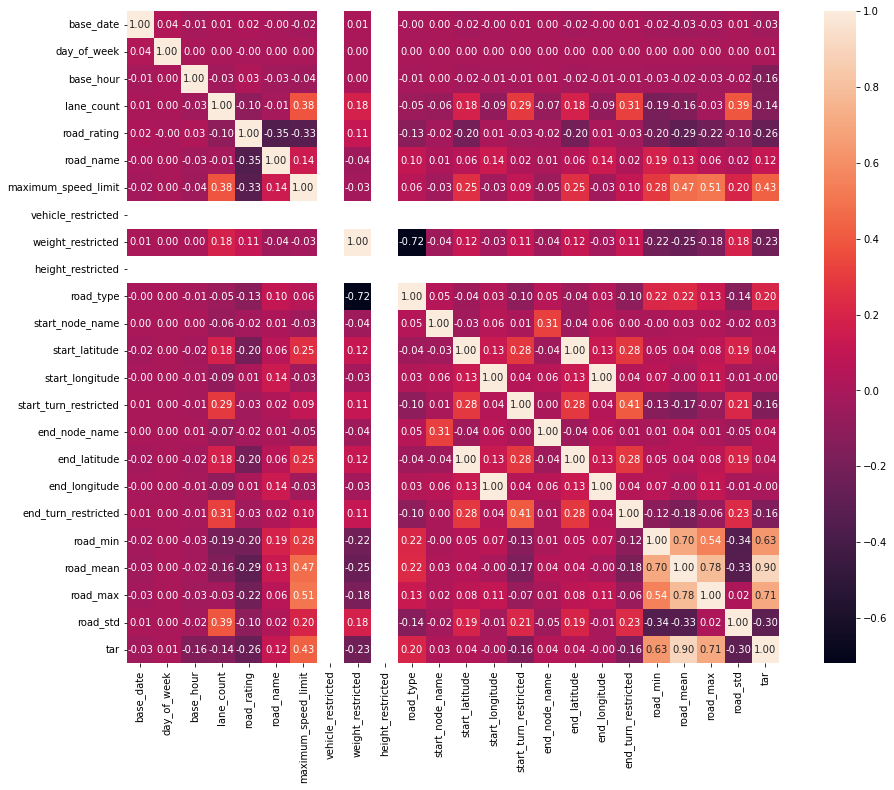

In [352]:
train_corr = X_train.corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(train_corr, annot=True, fmt = '.2f', square=True)

In [353]:
# 예측에 방해되는 컬럼 삭제
X_train.drop(['tar', 'road_code'], axis=1, inplace=True)

In [354]:
X_test.drop(['road_code'], axis=1, inplace=True)

## 4-16 전처리 후 재시각화

#### 범주형 데이터 산점도

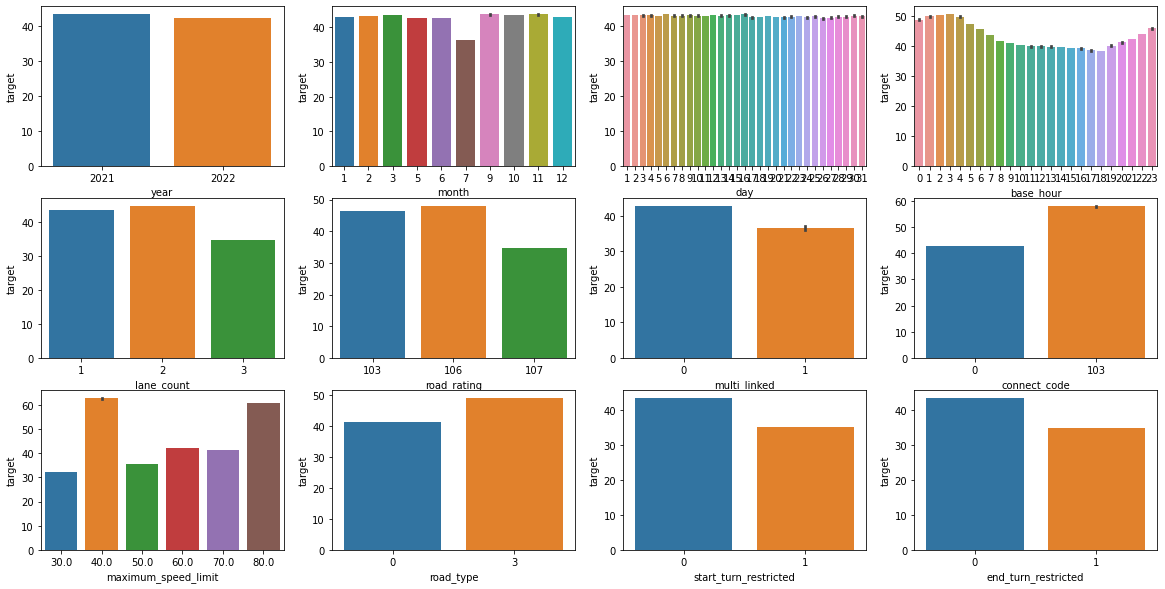

In [154]:
figure, axes = plt.subplots(3,4)
figure.set_size_inches(20, 10)
sns.barplot(data=X_train, x='year', y='target',ax=axes[0][0])
sns.barplot(data=X_train, x='month', y='target',ax=axes[0][1])
sns.barplot(data=X_train, x='day', y='target',ax=axes[0][2])
sns.barplot(data=X_train, x='base_hour', y='target',ax=axes[0][3])
sns.barplot(data=X_train, x='lane_count', y='target',ax=axes[1][0])
sns.barplot(data=X_train, x='road_rating', y='target',ax=axes[1][1])
sns.barplot(data=X_train, x='multi_linked', y='target',ax=axes[1][2])
sns.barplot(data=X_train, x='connect_code', y='target',ax=axes[1][3])
sns.barplot(data=X_train, x='maximum_speed_limit', y='target',ax=axes[2][0])
sns.barplot(data=X_train, x='road_type', y='target',ax=axes[2][1])
sns.barplot(data=X_train, x='start_turn_restricted', y='target',ax=axes[2][2])
sns.barplot(data=X_train, x='end_turn_restricted', y='target',ax=axes[2][3])


plt.show()

#### 시간, 월별 추가정보

<AxesSubplot:xlabel='month', ylabel='target'>

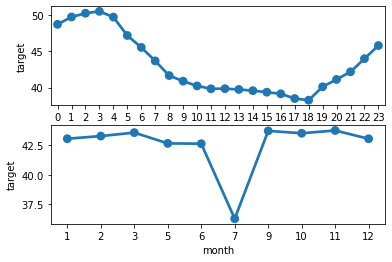

In [21]:
figure, (ax1, ax2) = plt.subplots(nrows=2)
sns.pointplot(data=X_train, x="base_hour", y="target", ax=ax1)
sns.pointplot(data=X_train, x="month", y="target", ax=ax2)

#### 18일과 7월에 정체가 더 심화됨을 알 수 있다.

In [67]:
#from sklearn.preprocessing import LabelEncoder

#items =  ['day_of_week', 'road_name', 'start_node_name', 'start_turn_restricted', 'end_node_name', 'end_turn_restricted']
#train = train.copy()
#encoder = LabelEncoder()

#for i in items:
#    encoder = LabelEncoder()
#    encoder.fit(train[i])
#    train[i] = encoder.transform(train[i])


,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,1,17,1,106,46,0,0,60.0,...,3,386,33.427747,126.662612,0,386,33.427749,126.662335,0,52.0
1,TRAIN_0000001,20220728,1,21,2,103,34,0,0,60.0,...,0,32,33.500730,126.529107,1,2,33.504811,126.526240,0,30.0
2,TRAIN_0000002,20211010,4,7,2,103,36,0,0,80.0,...,0,426,33.279145,126.368598,0,179,33.280072,126.362147,0,61.0
3,TRAIN_0000003,20220311,0,13,2,107,57,0,0,50.0,...,0,58,33.246081,126.567204,0,203,33.245565,126.566228,0,20.0
4,TRAIN_0000004,20211005,6,8,2,103,35,0,0,80.0,...,0,267,33.462214,126.326551,0,269,33.462677,126.330152,0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,1,16,1,107,0,0,0,50.0,...,0,79,33.422145,126.278125,0,42,33.420955,126.273750,0,20.0
4701213,TRAIN_4701213,20220331,1,2,2,107,0,0,0,80.0,...,3,31,33.472505,126.424368,0,31,33.472525,126.424890,0,65.0
4701214,TRAIN_4701214,20220613,3,22,2,103,35,0,0,60.0,...,0,19,33.447183,126.912579,0,214,33.444121,126.912948,0,30.0
4701215,TRAIN_4701215,20211020,2,2,2,103,37,0,0,80.0,...,0,392,33.443596,126.431817,0,23,33.444996,126.433332,0,73.0


In [40]:

X_train, X_test, y_train, y_test = train_test_split(X_train, y_test, test_size = 0.2, random_state = 42)


# 5. Modeling

## 5-1 LR (선형)

In [41]:

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

scores = cross_val_score(lin_reg, X_train, y_train, scoring = 'neg_mean_squared_error', cv = 5)
lin_reg_rmse = np.sqrt((-scores).mean())
lin_reg_rmse


12.58878925952928

## 5-2 DTR (트리)

In [42]:

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()

tree_scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)

tree_rmse = np.sqrt(-tree_scores).mean()
tree_rmse



5.762942764000505

## 5-3 Ridge(릿지)

In [43]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()
from sklearn.model_selection import GridSearchCV

In [44]:
# 평가지표 계산 함수
from sklearn.metrics import make_scorer
# log 값 변환 시 언더플로우 영향으로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred, convertExp=True):
    if convertExp:
        y = np.expm1(y)
        pred = np.expm1(pred)
    
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [45]:
# 릿지모델
ridge = Ridge()
ridge_params = {'alpha' : [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]} # 14개
gridsearch_ridge = GridSearchCV(ridge, ridge_params, scoring=rmsle_scorer, cv=5, n_jobs=-1) # 14 * 5

In [46]:
%time gridsearch_ridge.fit(X_train, y_train)

CPU times: total: 6.38 s
Wall time: 1min 20s


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [47]:
gridsearch_ridge.best_params_

{'alpha': 0.1}

In [48]:
cvres = gridsearch_ridge.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(-mean_score, params) # rmsle와 그 때의 하이퍼 파라미터

12.588786599362003 {'alpha': 0.1}
12.588786692168853 {'alpha': 1}
12.588787246469451 {'alpha': 2}
12.588788185941212 {'alpha': 3}
12.588789435047687 {'alpha': 4}
12.58880067305844 {'alpha': 10}
12.588843843630762 {'alpha': 30}
12.588922989673593 {'alpha': 100}
12.58896273188661 {'alpha': 200}
12.588980369917937 {'alpha': 300}
12.58899040688326 {'alpha': 400}
12.589008071609262 {'alpha': 800}
12.589010468154935 {'alpha': 900}
12.589012543748403 {'alpha': 1000}


## 5-4 Ensemble(앙상블)

### 5-4-1 Baggig(배깅)

In [50]:
from sklearn.ensemble import BaggingRegressor

In [ ]:
bag = BaggingRegressor(LinearRegression())

bag_params = {'n_estimators':[300,500,700,1000],'max_samples':[100,200,300]}

gridsearch_bag = GridSearchCV(bag,bag_params,scoring='neg_mean_absolute_error'
                                 ,cv= 5,n_jobs=-1)
gridsearch_bag.fit(X_train,y_train)


In [ ]:
GridSearchCV(cv=5,
             estimator=BaggingRegressor(base_estimator=LinearRegression()),
             n_jobs=-1,
             param_grid={'max_samples': [100, 200, 300],
                         'n_estimators': [300, 500, 700, 1000]},
             scoring='neg_mean_absolute_error')

In [ ]:
cvres = gridsearch_bag.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(-mean_score, params) # rmsle와 그 때의 하이퍼 파라미터

### 5-4-2 RFR(랜덤포레스트)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()

rf_scores = cross_val_score(rf_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=2, n_jobs=-1)

rf_rmse = np.sqrt(-rf_scores).mean()
rf_rmse

### 5-4-3 Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gbrt_params = { 'learning_rate' : [0.01, 0.02, 0.03, 0.04],
               'n_estimators' : [1000, 1500],
               'subsample' : [0.9, 0.5, 0.2],
               'max_depth' : [2, 4, 6, 8]
    
}

gbrt = GradientBoostingRegressor()

gridsearch_gbrt = GridSearchCV(gbrt, gbrt_params, scoring=rmsle_scorer, cv=5, n_jobs=-1)

In [ ]:
%time gridsearch_gbrt.fit(X_train, y_train)

In [ ]:
cvres = gridsearch_gbrt.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(-mean_score, params)

# 6. 성능향상